# Setup

In [ ]:
%pip install torch-geometric
%pip install pynvml

In [2]:
import os
import math
import time
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cuda


# Data Preprocessing

In [3]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [8]:
## MUTAG
print('MUTAG Dataset')
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')
print(mutag_data[0])

train_val_data, test_data = train_test_split(mutag_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)
mutag_train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
mutag_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
mutag_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

mutag_num_features = mutag_data.num_features
mutag_num_classes = mutag_data.num_classes
print(f'MUTAG Dataset -> Num Features = {mutag_num_features}, Num Classes = {mutag_num_classes}')


## Simulated
print('\nSimulated Dataset')
simulated_adj = np.load(dataset_path + 'simulated_adj.npy')
simulated_adj = simulated_adj[:, :, :, :,0] #only take the domain 1
simulated_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
simulated_features = simulated_features[:, :, :, :,0]

simulated_pyg_data_list = convert_to_pyg_data(simulated_adj, simulated_features)
print(simulated_pyg_data_list[0])

simulated_num_features = simulated_pyg_data_list[0].x.shape[1]
all_labels = torch.cat([data.y for data in simulated_pyg_data_list])
simulated_num_classes = torch.unique(all_labels).numel()
print(f'Num Features = {simulated_num_features}, Num Classes = {simulated_num_features}')


## EMCI-AD
print('\nEMCI-AD Dataset')
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_cleaned = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy') 
emci_pyg_data_list = convert_to_pyg_data(emci_cleaned, emci_features)
print(emci_pyg_data_list[0])

emci_num_features = emci_pyg_data_list[0].x.shape[1]
all_labels = torch.cat([data.y for data in emci_pyg_data_list])
emci_num_classes = torch.unique(all_labels).numel()
print(f'Num Features = {emci_num_features}, Num Classes = {emci_num_classes}')

batch_size = 10
set_seed(42)
emci_train_val_data, emci_test_data = train_test_split(emci_pyg_data_list, test_size=0.2, random_state=42)
emci_train_data, emci_val_data= train_test_split(emci_train_val_data, test_size=0.1, random_state=42)
emci_train_loader = DataLoader(emci_train_data, batch_size=batch_size, shuffle=True)
emci_val_loader = DataLoader(emci_val_data, batch_size=batch_size, shuffle=False)
emci_test_loader = DataLoader(emci_test_data, batch_size=batch_size, shuffle=False)


## SLIM160
print('\nSLIM160 Dataset')
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy') 
slim160_pyg_data_list = convert_to_pyg_data(slim160_cleaned, slim160_features)
print(slim160_pyg_data_list[0])

slim160_num_features = slim160_pyg_data_list[0].x.shape[1]
all_labels = torch.cat([data.y for data in slim160_pyg_data_list])
slim160_num_classes = torch.unique(all_labels).numel()
print(f'Num Features = {slim160_num_features}, Num Classes = {slim160_num_classes}')

batch_size = 32
set_seed(42)
slim160_train_val_data, slim160_test_data = train_test_split(slim160_pyg_data_list, test_size=0.2, random_state=42)
slim160_train_data, slim160_val_data= train_test_split(slim160_train_val_data, test_size=0.1, random_state=42)
slim160_train_loader = DataLoader(slim160_train_data, batch_size=batch_size, shuffle=True)
slim160_val_loader = DataLoader(slim160_val_data, batch_size=batch_size, shuffle=False)
slim160_test_loader = DataLoader(slim160_test_data, batch_size=batch_size, shuffle=False)

MUTAG Dataset
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
MUTAG Dataset -> Num Features = 7, Num Classes = 2

Simulated Dataset
Data(x=[35, 8], edge_index=[2, 1190], edge_attr=[1190], y=[1])
Num Features = 8, Num Classes = 8

EMCI-AD Dataset
Data(x=[35, 8], edge_index=[2, 1178], edge_attr=[1178], y=[1])
Num Features = 8, Num Classes = 2

SLIM160 Dataset
Data(x=[160, 8], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Num Features = 8, Num Classes = 3


# Models

In [46]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## GCN Models
class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## GCESN Model
class RidgeLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=1):
        super(RidgeLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.alpha = alpha

    def forward(self, x):
        return self.linear(x)

    def ridge_regularization(self):
        return self.alpha * torch.sum(self.linear.weight ** 2)

class GCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = self.ridge_layer(h)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer_1 = RidgeLayer(hidden_features, 2*hidden_features, ridge_alpha)
        self.ridge_layer_2 = RidgeLayer(2*hidden_features, hidden_features, 0.7)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.ridge_layer_1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.ridge_layer_2(h)

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## TrainableGCESN Model
class SpectralRadiusOptimizerHook:
    def __init__(self, model):
        self.model = model

    def __call__(self):
        self.model.adjust_spectral_radius()

class TrainableGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(TrainableGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        
        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W.data *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h_new = F.relu(torch.mm(adj, torch.mm(h, self.W)))
            h = (1 - self.leaky_rate) * h + self.leaky_rate * h_new
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Decoupled GCESN Model
class decoupledGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        # set_seed(42) 
        state = torch.zeros(n_node, self.hidden_features).to(device)
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win) + torch.mm(state, self.W)))
        
        x = self.ridge_layer(state)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class decoupledGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.ridge_layer_1 = RidgeLayer(hidden_features, 2*hidden_features, ridge_alpha)
        
        self.gcn2 = GCN(hidden_features, 2*hidden_features)
        self.fc = nn.Linear(2*hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1   = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.Win_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2   = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = torch.zeros(n_node, self.hidden_features).to(device)
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_1) + torch.mm(state, self.W_1)))
        state = self.ridge_layer_1(state)

        h = F.relu(self.gcn2(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_2) + torch.mm(state, self.W_2)))
        
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Trainings & Evaluations

In [41]:
## Single Functions
def single_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.1, save_path='models/gcn_x.pth', 
                binary_classification=True, is_esn=False):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    spectral_hook = SpectralRadiusOptimizerHook(model)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            if is_esn==True:
                spectral_hook()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch + 1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage_percent:.2f}%')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')
    print(f'Max GPU Usage: {max_gpu_usage:.2f}GB')
    print(f'Max GPU Utilization: {max_gpu_usage_percent:.2f}%')

    return

def binary_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return accuracy, sensitivity, specificity

def multiclass_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity
    
def single_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Average Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Average Specificity: {specificity:.4f}')
    return 

def inference_performance(model, loader):
    model.eval()
    total_inference_time = 0
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    # Get the process object for the current process
    process = psutil.Process()

    for data in loader:
        x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
        
        # Measure CPU and GPU usage before inference
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        start_time = time.time()
        with torch.no_grad():
            output = model(x, adj_matrix, batch)
        end_time = time.time()

        # Measure CPU and GPU usage after inference
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during inference
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Calculate inference time
        inference_time = end_time - start_time
        total_inference_time += inference_time

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_inference_time = total_inference_time / len(loader)  # Average inference time per batch

    print(f'\nAverage Inference Time per Batch: {total_inference_time:.4f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    return 

## Multiple Runs
def multi_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.1, binary_classification=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    total_training_time = np.sum(epoch_time)
    avg_epoch_time = np.mean(epoch_time)

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_memory_usage = np.mean(memory_usage)

    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_gpu_usage = np.max(gpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_epoch, total_training_time, avg_epoch_time, avg_cpu_usage_percent, avg_gpu_usage, avg_memory_usage, max_cpu_usage_percent, max_gpu_usage, max_memory_usage 
   
def multi_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    return accuracy, sensitivity, specificity

def multi_train_test(model, train_loader, val_loader, test_loader, num_runs=10, 
                     lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                     binary_classification=True, best_model_path='models/best_model.pth'):

    all_accuracies = []
    all_sensitivities = []
    all_specificities = []

    all_training_times = []
    all_epoch_time = []
    all_epoch = []

    all_avg_cpu_usages = []
    all_avg_gpu_usages = []
    all_avg_memory_usages = []

    all_max_cpu_usages = []
    all_max_gpu_usages = []
    all_max_memory_usages = []
    
    best_accuracy = -float('inf')
    best_model_state = None

    for run in range(num_runs):
        set_seed(run)
        model.initialize_weights()
        loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(model, train_loader, 
                                                                                                                val_loader, lr=lr, num_epochs=num_epochs)

        accuracy, sensitivity, specificity = multi_test(model, test_loader, binary_classification)

        # Check if current model is the best so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)

        all_training_times.append(training_time)
        all_epoch_time.append(epoch_time)
        all_epoch.append(total_epoch)

        all_avg_cpu_usages.append(avg_cpu)
        all_avg_gpu_usages.append(avg_gpu)
        all_avg_memory_usages.append(avg_memory)

        all_max_cpu_usages.append(max_cpu)
        all_max_gpu_usages.append(max_gpu)
        all_max_memory_usages.append(max_memory)
        
        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss:.5f}, Total Training Time: {training_time:.2f}s')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, best_model_path)
        print(f'Best model saved to {best_model_path} with accuracy {best_accuracy:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)

    std_accuracy = np.std(all_accuracies)
    std_sensitivity = np.std(all_sensitivities)
    std_specificity = np.std(all_specificities)

    max_accuracy = np.max(all_accuracies)
    max_sensitivity = np.max(all_sensitivities)
    max_specificity = np.max(all_specificities)

    avg_training_time = np.mean(all_training_times)
    avg_epoch_time = np.mean(all_epoch_time)
    avg_num_epoch = np.mean(all_epoch)

    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_gpu_usage = np.mean(all_avg_gpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)

    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_gpu_usage = np.mean(all_max_gpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.2f}, Avg Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.2f}, Avg Specificity: {avg_specificity:.4f} ± {std_specificity:.2f}')
    print(f'  Max Accuracy: {max_accuracy:.4f}, Max Sensitivity: {max_sensitivity:.4f}, Max Specificity: {max_specificity:.4f}')
    print(f'  Avg Num Epoch: {avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s, Avg Epoch Time: {avg_epoch_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}%, Avg GPU Usage: {avg_gpu_usage:.2f}%, Avg Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'  Avg Max CPU Usage: {avg_max_cpu_usage:.2f}%, Avg Max GPU Usage: {avg_max_gpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

    return


## GCN

### GCN 1-Layer

#### MUTAG

GCN1Layer(
  (gcn1): GCN (7 -> 14)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 284

Epoch 1, Train Loss: 94.14867669343948, Val Loss: 10.549120903015137
Time: 0.65s, CPU: 14.30%, Memory: 2.96GB, GPU: 0.01GB, GPU Util: 2.50%
Epoch 2, Train Loss: 84.44917124509811, Val Loss: 11.329366564750671
Time: 0.02s, CPU: 12.45%, Memory: 3.20GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 81.2327116727829, Val Loss: 11.756115853786469
Time: 0.03s, CPU: 22.90%, Memory: 3.20GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 80.24670839309692, Val Loss: 11.568962037563324
Time: 0.03s, CPU: 46.65%, Memory: 3.20GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 79.62163537740707, Val Loss: 11.206330955028534
Time: 0.03s, CPU: 18.75%, Memory: 3.20GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 6, Train Loss: 79.45931965112686, Val Loss: 10.95899909734726
Time: 0.03s, CPU: 23.05%, Memory: 3.20GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 7, Train Loss: 79.

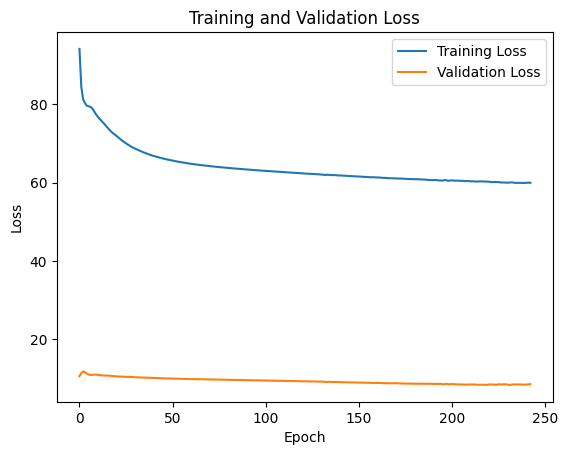

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 12.95%
Average Memory Usage: 3.20GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 3.70%

Total Training Time: 6.72s
Max CPU Usage: 46.65%
Max Memory Usage: 3.20GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 5.00%


In [8]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())*2}\n")
single_train(gcn1_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_1l_mutag.pth')

In [43]:
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn1_mutag.load_state_dict(torch.load('models/gcn_1l_mutag.pth'))
single_test(gcn1_mutag.to(device), mutag_test_loader)
inference_performance(gcn1_mutag.to(device), mutag_test_loader)

Accuracy: 0.8158
Average Sensitivity (Recall): 0.8462
Average Specificity: 0.7500

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 11.52%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### EMCI-AD

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 356

Epoch 1, Train Loss: 66.93576407432556, Val Loss: 7.578530550003052
Time: 0.04s, CPU: 11.25%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 66.36269629001617, Val Loss: 7.604725003242493
Time: 0.04s, CPU: 8.35%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 66.47167122364044, Val Loss: 7.6201446652412415
Time: 0.04s, CPU: 6.05%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 66.5421656370163, Val Loss: 7.611989200115204
Time: 0.05s, CPU: 21.85%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 66.51615309715271, Val Loss: 7.603678464889526
Time: 0.04s, CPU: 15.35%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 6, Train Loss: 66.48370838165283, Val Loss: 7.601607263088226
Time: 0.05s, CPU: 18.15%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 7, Train Loss: 66.465881

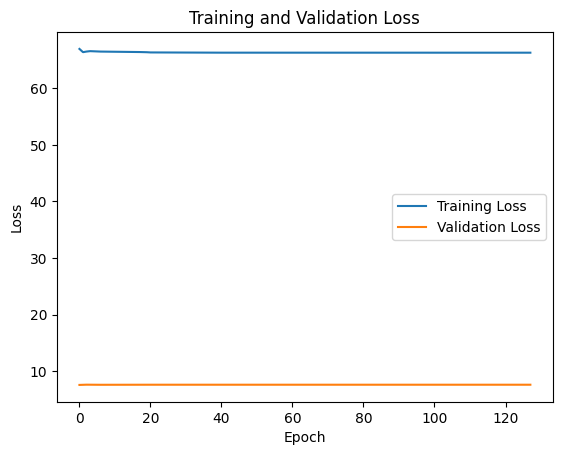

Model saved to models/gcn_1l_emci.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 13.53%
Average Memory Usage: 3.21GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.70%

Total Training Time: 5.60s
Max CPU Usage: 44.30%
Max Memory Usage: 3.21GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%


In [10]:
set_seed(42)
gcn1_emci = GCN1Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn1_emci)
print(f"Total number of trainable parameters: {(gcn1_emci.count_parameters())*2}\n")
single_train(gcn1_emci, emci_train_loader, emci_val_loader, 
            lr=0.01, num_epochs=500, step_size=20, patience=20, save_path='models/gcn_1l_emci.pth')


In [45]:
gcn1_emci = GCN1Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn1_emci.load_state_dict(torch.load('models/gcn_1l_emci.pth'))
single_test(gcn1_emci.to(device), emci_test_loader)
inference_performance(gcn1_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 30.63%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 390

Epoch 1, Train Loss: 260.04783940315247, Val Loss: 29.889315247535706
Time: 0.13s, CPU: 38.50%, Memory: 3.33GB, GPU: 0.34GB, GPU Util: 5.50%
Epoch 2, Train Loss: 256.00520634651184, Val Loss: 29.789150834083557
Time: 0.13s, CPU: 54.25%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 14.00%
Epoch 3, Train Loss: 255.32504272460938, Val Loss: 29.69202482700348
Time: 0.17s, CPU: 55.60%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 14.50%
Epoch 4, Train Loss: 253.5604054927826, Val Loss: 29.77241063117981
Time: 0.12s, CPU: 51.25%, Memory: 3.34GB, GPU: 0.38GB, GPU Util: 12.00%
Epoch 5, Train Loss: 251.8092291355133, Val Loss: 29.8782559633255
Time: 0.17s, CPU: 50.30%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 17.00%
Epoch 6, Train Loss: 250.1774344444275, Val Loss: 29.931592226028442
Time: 0.13s, CPU: 46.35%, Memory: 3.34GB, GPU: 0.38GB, GPU Util: 15.50%
Epoch 7, Train Los

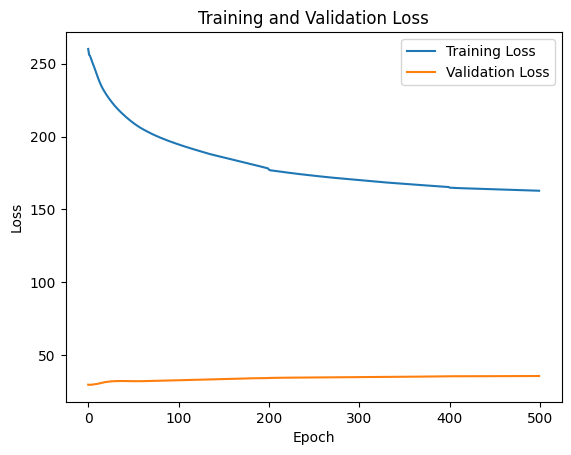

Model saved to models/gcn_1l_slim160.pth
Average Time per Epoch: 0.30s
Average CPU Usage: 55.50%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.38GB
Average GPU Utilization: 13.72%

Total Training Time: 151.67s
Max CPU Usage: 91.35%
Max Memory Usage: 3.36GB
Max GPU Usage: 0.38GB
Max GPU Utilization: 21.00%


In [16]:
set_seed(42)
gcn1_slim160 = GCN1Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn1_slim160)
print(f"Total number of trainable parameters: {(gcn1_slim160.count_parameters())*2}\n")
single_train(gcn1_slim160, slim160_train_loader, slim160_val_loader, 
            lr=0.01, num_epochs=500, step_size=200, gamma=0.5,
            save_path='models/gcn_1l_slim160.pth', binary_classification=False)


In [46]:
gcn1_slim160 = GCN1Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn1_slim160.load_state_dict(torch.load('models/gcn_1l_slim160.pth'))
single_test(gcn1_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn1_slim160.to(device), slim160_test_loader)

Accuracy: 0.3788
Average Sensitivity (Recall): 0.3981
Average Specificity: 0.6925

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 35.02%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 1.00%


### GCN 2-Layer

#### MUTAG

GCN2Layer(
  (gcn1): GCN (7 -> 14)
  (gcn2): GCN (14 -> 28)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1180

Epoch 1, Train Loss: 86.46721732616425, Val Loss: 11.68528139591217
Time: 0.03s, CPU: 18.45%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 0.50%
Epoch 2, Train Loss: 80.85846072435379, Val Loss: 11.765201389789581
Time: 0.04s, CPU: 24.50%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 1.00%
Epoch 3, Train Loss: 79.94231593608856, Val Loss: 11.294539868831635
Time: 0.03s, CPU: 28.90%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 1.00%
Epoch 4, Train Loss: 79.69838243722916, Val Loss: 10.979202389717102
Time: 0.03s, CPU: 21.45%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 1.00%
Epoch 5, Train Loss: 78.92959696054459, Val Loss: 10.866539776325226
Time: 0.03s, CPU: 19.70%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 2.50%
Epoch 6, Train Loss: 77.34769850969315, Val Loss: 10.953080356121063
Time: 0.03s, CPU: 28.65%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 4.0

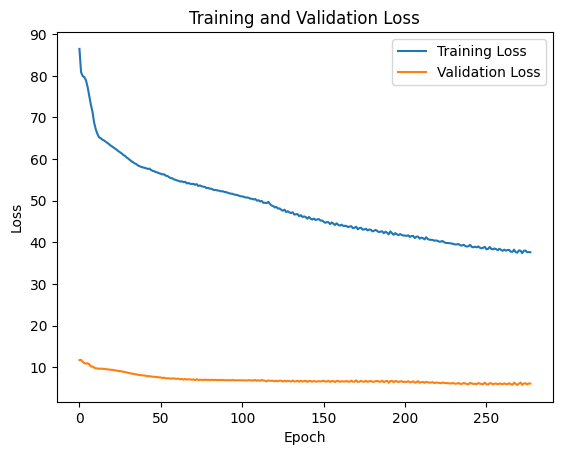

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 28.03%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.34GB
Average GPU Utilization: 3.35%

Total Training Time: 9.49s
Max CPU Usage: 64.35%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.34GB
Max GPU Utilization: 5.00%


In [20]:
set_seed(42)
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn2_mutag)
print(f"Total number of trainable parameters: {(gcn2_mutag.count_parameters())*2}\n")
single_train(gcn2_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_2l_mutag.pth')

In [21]:
single_test(gcn2_mutag, mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.8846
Average Specificity: 1.0000


#### EMCI-AD

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1508

Epoch 1, Train Loss: 71.56606495380402, Val Loss: 7.8566460609436035
Time: 0.07s, CPU: 17.05%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 0.00%
Epoch 2, Train Loss: 68.20633161067963, Val Loss: 7.5821457505226135
Time: 0.06s, CPU: 26.35%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 1.50%
Epoch 3, Train Loss: 66.41744589805603, Val Loss: 7.683176159858704
Time: 0.06s, CPU: 25.45%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 3.00%
Epoch 4, Train Loss: 66.86147153377533, Val Loss: 7.593149483203888
Time: 0.07s, CPU: 23.65%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 3.50%
Epoch 5, Train Loss: 66.37889873981476, Val Loss: 7.639395236968994
Time: 0.06s, CPU: 21.15%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 4.00%
Epoch 6, Train Loss: 66.55304217338562, Val Loss: 7.621022880077362
Time: 0.07s, CPU: 21.35%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 4.00%


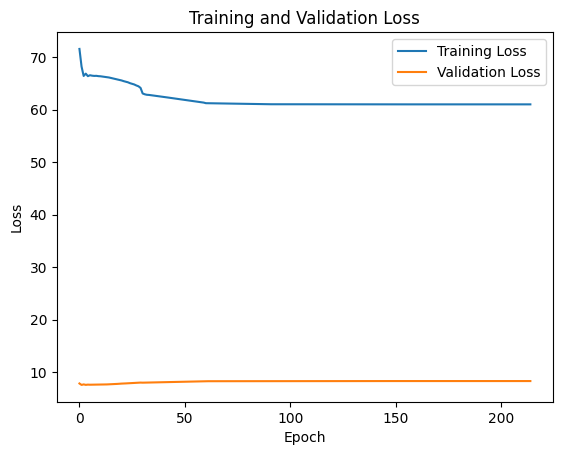

Model saved to models/gcn_2l_emci.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 20.03%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.34GB
Average GPU Utilization: 4.72%

Total Training Time: 11.65s
Max CPU Usage: 48.25%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.34GB
Max GPU Utilization: 6.00%


In [22]:
set_seed(42)
gcn2_emci = GCN2Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn2_emci)
print(f"Total number of trainable parameters: {(gcn2_emci.count_parameters())*2}\n")
single_train(gcn2_emci, emci_train_loader, emci_val_loader, 
            lr=0.01, num_epochs=500, step_size=30, patience=10, save_path='models/gcn_2l_emci.pth')


In [48]:
gcn2_emci = GCN2Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn2_emci.load_state_dict(torch.load('models/gcn_2l_emci.pth'))
single_test(gcn2_emci.to(device), emci_test_loader)
inference_performance(gcn2_emci.to(device), emci_test_loader)

Accuracy: 0.5556
Average Sensitivity (Recall): 0.5455
Average Specificity: 0.5625

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 14.90%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1574

Epoch 1, Train Loss: 508.5967903137207, Val Loss: 39.408928871154785
Time: 0.22s, CPU: 40.60%, Memory: 3.36GB, GPU: 0.45GB, GPU Util: 4.00%
Epoch 2, Train Loss: 278.14805006980896, Val Loss: 32.664613008499146
Time: 0.15s, CPU: 51.15%, Memory: 3.36GB, GPU: 0.49GB, GPU Util: 13.00%
Epoch 3, Train Loss: 258.1234874725342, Val Loss: 31.4747132062912
Time: 0.13s, CPU: 53.50%, Memory: 3.37GB, GPU: 0.49GB, GPU Util: 20.00%
Epoch 4, Train Loss: 241.13186943531036, Val Loss: 31.333887577056885
Time: 0.14s, CPU: 43.65%, Memory: 3.39GB, GPU: 0.49GB, GPU Util: 22.50%
Epoch 5, Train Loss: 240.39900135993958, Val Loss: 30.568740248680115
Time: 0.14s, CPU: 48.30%, Memory: 3.37GB, GPU: 0.49GB, GPU Util: 22.00%
Epoch 6, Train Loss: 229.95044255256653, Val Loss: 30.631211042404175
Time: 0.35s, CPU: 34.30%, Memory: 3.38GB, GPU: 0.33GB, GPU Ut

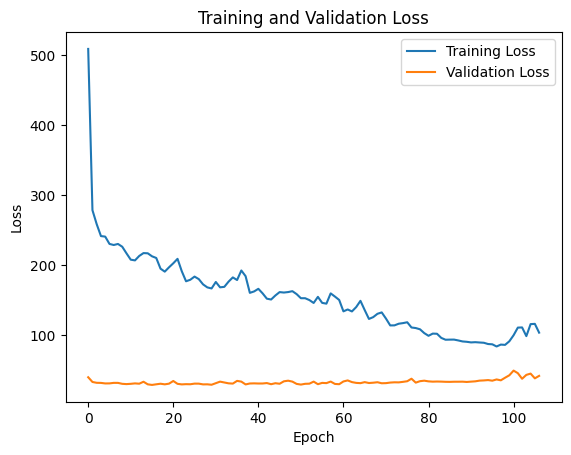

Model saved to models/gcn_2l_slim160.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 50.35%
Average Memory Usage: 3.37GB
Average GPU Usage: 0.18GB
Average GPU Utilization: 21.59%

Total Training Time: 15.64s
Max CPU Usage: 80.55%
Max Memory Usage: 3.39GB
Max GPU Usage: 0.49GB
Max GPU Utilization: 28.00%


In [33]:
set_seed(42)
gcn2_slim160 = GCN2Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn2_slim160)
print(f"Total number of trainable parameters: {(gcn2_slim160.count_parameters())*2}\n")
single_train(gcn2_slim160, slim160_train_loader, slim160_val_loader, 
            lr=0.01, num_epochs=500, step_size=75, patience=10, gamma=0.5,
            save_path='models/gcn_2l_slim160.pth', binary_classification=False)


In [50]:
gcn2_slim160 = GCN2Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn2_slim160.load_state_dict(torch.load('models/gcn_2l_slim160.pth'))
single_test(gcn2_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn2_slim160.to(device), slim160_test_loader)

Accuracy: 0.4091
Average Sensitivity (Recall): 0.4120
Average Specificity: 0.7034

Average Inference Time per Batch: 0.0015s
Average CPU Usage: 36.37%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 1.33%


## GCESN

### GCESN 1-Layer

#### MUTAG

In [51]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=6)
print(gcesn_mutag)
print(f"Total number of trainable parameters: {gcesn_mutag.count_parameters()}\n")

multi_train_test(gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_gcesn_1l_mutag.pth')


GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 240


Run 1/50 -> Loss: 67.46716, Total Training Time: 7.99s
  Accuracy: 0.7105, Sensitivity: 1.0000, Specificity: 0.0833

Run 2/50 -> Loss: 66.33404, Total Training Time: 0.68s
  Accuracy: 0.6842, Sensitivity: 1.0000, Specificity: 0.0000

Run 3/50 -> Loss: 76.58904, Total Training Time: 7.44s
  Accuracy: 0.7368, Sensitivity: 1.0000, Specificity: 0.1667

Run 4/50 -> Loss: 65.63456, Total Training Time: 7.27s
  Accuracy: 0.7632, Sensitivity: 0.9231, Specificity: 0.4167

Run 5/50 -> Loss: 72.87041, Total Training Time: 7.29s
  Accuracy: 0.7368, Sensitivity: 1.0000, Specificity: 0.1667

Run 6/50 -> Loss: 55.21590, Total Training Time: 7.11s
  Accuracy: 0.7632, Sensitivity: 0.9231, Specificity: 0.4167

Run 7/50 -> Loss: 57.34009, Total Training Time: 6.44s
  Accuracy: 0.7895, Sensiti

In [58]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=6)
gcesn_mutag.initialize_weights()
gcesn_mutag.load_state_dict(torch.load('models/best_gcesn_1l_mutag.pth'))
single_test(gcesn_mutag.to(device), mutag_test_loader)
inference_performance(gcesn_mutag.to(device), mutag_test_loader)

Accuracy: 0.3158
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 14.18%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### EMCI-AD

In [60]:
gcesn_emci = GCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_emci)
print(f"Total number of trainable parameters: {gcesn_emci.count_parameters()}\n")

multi_train_test(gcesn_emci, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_gcesn_1l_emci.pth')

GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 306


Run 1/50 -> Loss: 66.47801, Total Training Time: 0.41s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 2/50 -> Loss: 66.47172, Total Training Time: 0.35s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 3/50 -> Loss: 66.47406, Total Training Time: 0.36s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 4/50 -> Loss: 66.48687, Total Training Time: 0.34s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 5/50 -> Loss: 66.46151, Total Training Time: 0.35s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 6/50 -> Loss: 66.47197, Total Training Time: 0.35s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 7/50 -> Loss: 66.46766, Total Training Time: 0.34s
  Accuracy: 0.4074, Sensiti

In [61]:
gcesn_emci = GCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
gcesn_emci.initialize_weights()
gcesn_emci.load_state_dict(torch.load('models/best_gcesn_1l_emci.pth'))
single_test(gcesn_emci.to(device), emci_test_loader)
inference_performance(gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.5926
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 8.65%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 3.00%


#### SLIM160

In [62]:
gcesn_slim160 = GCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_slim160)
print(f"Total number of trainable parameters: {gcesn_slim160.count_parameters()}\n")

multi_train_test(gcesn_slim160, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=False, best_model_path='models/best_gcesn_1l_slim160.pth')

GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 323


Run 1/50 -> Loss: 245.90678, Total Training Time: 40.15s
  Accuracy: 0.3788, Sensitivity: 0.4074, Specificity: 0.7054

Run 2/50 -> Loss: 251.17002, Total Training Time: 53.90s
  Accuracy: 0.2879, Sensitivity: 0.3333, Specificity: 0.6677

Run 3/50 -> Loss: 248.70386, Total Training Time: 94.14s
  Accuracy: 0.3182, Sensitivity: 0.3472, Specificity: 0.6736

Run 4/50 -> Loss: 247.93722, Total Training Time: 76.11s
  Accuracy: 0.3939, Sensitivity: 0.4213, Specificity: 0.7073

Run 5/50 -> Loss: 243.54635, Total Training Time: 98.12s
  Accuracy: 0.3636, Sensitivity: 0.3935, Specificity: 0.6964

Run 6/50 -> Loss: 240.13485, Total Training Time: 123.32s
  Accuracy: 0.3939, Sensitivity: 0.4028, Specificity: 0.7054

Run 7/50 -> Loss: 248.67035, Total Training Time: 60.01s
  Accuracy: 

In [63]:
gcesn_slim160 = GCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
gcesn_slim160.initialize_weights()
gcesn_slim160.load_state_dict(torch.load('models/best_gcesn_1l_slim160.pth'))
single_test(gcesn_slim160.to(device), slim160_test_loader)
inference_performance(gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.3333
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 39.18%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 15.67%


### GCESN 2-Layer

#### MUTAG

In [11]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_2)
print(f"Total number of trainable parameters: {gcesn_mutag_2.count_parameters()}\n")

multi_train_test(gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_gcesn_2l_mutag.pth')

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=28, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 856


Run 1/50 -> Loss: 67.29538, Total Training Time: 7.85s
  Accuracy: 0.7895, Sensitivity: 0.8846, Specificity: 0.5833

Run 2/50 -> Loss: 68.69862, Total Training Time: 6.10s
  Accuracy: 0.7368, Sensitivity: 0.8846, Specificity: 0.4167

Run 3/50 -> Loss: 68.42492, Total Training Time: 6.47s
  Accuracy: 0.7368, Sensitivity: 0.9231, Specificity: 0.3333

Run 4/50 -> Loss: 65.64970, Total Training Time: 6.67s
  Accuracy: 0.7368, Sensitivity: 0.8846, Specificity: 0.4167

Run 5/50 -> Loss: 57.23055, Total Training Time: 6.56s
  Accuracy: 0.8684, Sensitivity: 0.9231, Specificity: 0.7500

Run 6/50 -> Loss: 56.81438, Total Training Time: 5.96s
  Accuracy: 0.8421, Sensitivity: 0.8846, S

In [12]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=6)
gcesn_mutag_2.initialize_weights()
gcesn_mutag_2.load_state_dict(torch.load('models/best_gcesn_2l_mutag.pth'))
single_test(gcesn_mutag_2.to(device), mutag_test_loader)
inference_performance(gcesn_mutag_2.to(device), mutag_test_loader)

Accuracy: 0.6842
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0020s
Average CPU Usage: 19.00%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.00%


#### EMCI-AD

In [13]:
gcesn_emci_2 = GCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=3, ridge_alpha=0.9)
print(gcesn_emci_2)
print(f"Total number of trainable parameters: {gcesn_emci_2.count_parameters()}\n")

multi_train_test(gcesn_emci_2, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_gcesn_2l_emci.pth')

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 1106


Run 1/50 -> Loss: 1922.00609, Total Training Time: 1.16s
  Accuracy: 0.5926, Sensitivity: 0.0000, Specificity: 1.0000

Run 2/50 -> Loss: 4224.90617, Total Training Time: 0.90s
  Accuracy: 0.4815, Sensitivity: 1.0000, Specificity: 0.1250

Run 3/50 -> Loss: 3489.46293, Total Training Time: 0.91s
  Accuracy: 0.5556, Sensitivity: 0.1818, Specificity: 0.8125

Run 4/50 -> Loss: 2826.00755, Total Training Time: 2.00s
  Accuracy: 0.5926, Sensitivity: 0.0909, Specificity: 0.9375

Run 5/50 -> Loss: 1290.85168, Total Training Time: 2.58s
  Accuracy: 0.5556, Sensitivity: 0.1818, Specificity: 0.8125

Run 6/50 -> Loss: 251.10470, Total Training Time: 1.54s
  Accuracy: 0.3704, Sensitivit

In [14]:
gcesn_emci_2 = GCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=6)
gcesn_emci_2.initialize_weights()
gcesn_emci_2.load_state_dict(torch.load('models/best_gcesn_2l_emci.pth'))
single_test(gcesn_emci_2.to(device), emci_test_loader)
inference_performance(gcesn_emci_2.to(device), emci_test_loader)

Accuracy: 0.5926
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0016s
Average CPU Usage: 19.97%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.00%


#### SLIM160

In [15]:
gcesn_slim160_2 = GCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_slim160_2)
print(f"Total number of trainable parameters: {gcesn_slim160_2.count_parameters()}\n")

multi_train_test(gcesn_slim160_2, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=10, binary_classification=True, best_model_path='models/best_gcesn_2l_slim160.pth')

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 1123


Run 1/10 -> Loss: 220.32367, Total Training Time: 35.57s
  Accuracy: 0.6000, Sensitivity: 0.5000, Specificity: 0.6875

Run 2/10 -> Loss: 222.05566, Total Training Time: 38.33s
  Accuracy: 0.6429, Sensitivity: 0.6000, Specificity: 0.6667

Run 3/10 -> Loss: 237.57963, Total Training Time: 67.27s
  Accuracy: 0.5714, Sensitivity: 0.4444, Specificity: 0.6667

Run 4/10 -> Loss: 232.60611, Total Training Time: 56.87s
  Accuracy: 0.6538, Sensitivity: 0.5833, Specificity: 0.7143

Run 5/10 -> Loss: 226.13063, Total Training Time: 50.87s
  Accuracy: 0.5789, Sensitivity: 0.4000, Specificity: 0.6429

Run 6/10 -> Loss: 217.02539, Total Training Time: 67.51s
  Accuracy: 0.5714, Sensitivi

In [16]:
gcesn_slim160_2 = GCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=6)
gcesn_slim160_2.initialize_weights()
gcesn_slim160_2.load_state_dict(torch.load('models/best_gcesn_2l_slim160.pth'))
single_test(gcesn_slim160_2.to(device), slim160_test_loader)
inference_performance(gcesn_slim160_2.to(device), slim160_test_loader)

Accuracy: nan
Average Sensitivity (Recall): 0.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0064s
Average CPU Usage: 18.85%
Average Memory Usage: 3.30GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 4.00%


/tmp/ipykernel_37/3672718425.py:155: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = (TP + TN) / (TP + TN + FP + FN)


## Decoupled GCESN

### 1-Layer

#### MUTAG

In [17]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (7 -> 14)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 352


Run 1/50 -> Loss: 70.56559, Total Training Time: 6.96s
  Accuracy: 0.7105, Sensitivity: 0.9615, Specificity: 0.1667

Run 2/50 -> Loss: 71.67577, Total Training Time: 6.31s
  Accuracy: 0.7895, Sensitivity: 0.9231, Specificity: 0.5000

Run 3/50 -> Loss: 72.48537, Total Training Time: 6.61s
  Accuracy: 0.7105, Sensitivity: 0.9615, Specificity: 0.1667

Run 4/50 -> Loss: 69.26342, Total Training Time: 6.60s
  Accuracy: 0.7632, Sensitivity: 1.0000, Specificity: 0.2500

Run 5/50 -> Loss: 75.93545, Total Training Time: 6.92s
  Accuracy: 0.7105, Sensitivity: 0.9231, Specificity: 0.2500

Run 6/50 -> Loss: 66.12871, Total Training Time: 6.40s
  Accuracy: 0.7895, Sensitivity: 0.9231, Specificity: 0.5000

Run 7/50 -> Loss: 67.54536, Total Training Time: 

In [20]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
decoupled_gcesn_mutag.initialize_weights()
decoupled_gcesn_mutag.load_state_dict(torch.load('models/best_decoupledgcesn_1l_mutag.pth'))
single_test(decoupled_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag.to(device), mutag_test_loader)

Accuracy: 0.3158
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 44.08%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### EMCI-AD

In [18]:
decoupled_gcesn_emci = decoupledGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
print(decoupled_gcesn_emci)
print(f"Total number of trainable parameters: {decoupled_gcesn_emci.count_parameters()}\n")

multi_train_test(decoupled_gcesn_emci, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.01, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_emci.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 450


Run 1/50 -> Loss: 41.66671, Total Training Time: 10.69s
  Accuracy: 0.5185, Sensitivity: 0.5455, Specificity: 0.5000

Run 2/50 -> Loss: 49.73309, Total Training Time: 11.02s
  Accuracy: 0.2963, Sensitivity: 0.4545, Specificity: 0.1875

Run 3/50 -> Loss: 43.67198, Total Training Time: 10.97s
  Accuracy: 0.2593, Sensitivity: 0.2727, Specificity: 0.2500

Run 4/50 -> Loss: 51.25417, Total Training Time: 10.62s
  Accuracy: 0.4444, Sensitivity: 0.4545, Specificity: 0.4375

Run 5/50 -> Loss: 48.27971, Total Training Time: 10.74s
  Accuracy: 0.2593, Sensitivity: 0.2727, Specificity: 0.2500

Run 6/50 -> Loss: 54.26389, Total Training Time: 1.80s
  Accuracy: 0.5185, Sensitivity: 0.2727, Specificity: 0.6875

Run 7/50 -> Loss: 54.29724, Total Training T

In [21]:
decoupled_gcesn_emci = decoupledGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=2)
decoupled_gcesn_emci.initialize_weights()
decoupled_gcesn_emci.load_state_dict(torch.load('models/best_decoupledgcesn_1l_emci.pth'))
single_test(decoupled_gcesn_emci.to(device), emci_test_loader)
inference_performance(decoupled_gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 9.12%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### SLIM160

In [19]:
decoupled_gcesn_slim160 = decoupledGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=2)
print(decoupled_gcesn_slim160)
print(f"Total number of trainable parameters: {decoupled_gcesn_slim160.count_parameters()}\n")

multi_train_test(decoupled_gcesn_slim160, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=10, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_slim160.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 467


Run 1/10 -> Loss: 235.58989, Total Training Time: 44.69s
  Accuracy: 0.5000, Sensitivity: 0.2857, Specificity: 0.6154

Run 2/10 -> Loss: 228.54427, Total Training Time: 60.16s
  Accuracy: 0.6087, Sensitivity: 0.1429, Specificity: 0.8125

Run 3/10 -> Loss: 234.29372, Total Training Time: 50.72s
  Accuracy: 0.7000, Sensitivity: 0.1667, Specificity: 0.9286

Run 4/10 -> Loss: 236.59297, Total Training Time: 34.34s
  Accuracy: 0.6552, Sensitivity: 0.4167, Specificity: 0.8235

Run 5/10 -> Loss: 225.60957, Total Training Time: 70.10s
  Accuracy: 0.6250, Sensitivity: 0.5000, Specificity: 0.6875

Run 6/10 -> Loss: 221.92148, Total Training Time: 51.15s
  Accuracy: 0.5926, Sensitivity: 0.3000, Specificity: 0.7647

Run 7/10 -> Loss: 218.74750, Total Tr

In [22]:
decoupled_gcesn_slim160 = decoupledGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=2)
decoupled_gcesn_slim160.initialize_weights()
decoupled_gcesn_slim160.load_state_dict(torch.load('models/best_decoupledgcesn_1l_slim160.pth'))
single_test(decoupled_gcesn_slim160.to(device), slim160_test_loader)
inference_performance(decoupled_gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.4762
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0435

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 37.88%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 2.00%


### 2-Layer

#### MUTAG

In [23]:
decoupled_gcesn_mutag_2 = decoupledGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
print(decoupled_gcesn_mutag_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_mutag.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (7 -> 14)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (gcn2): GCN (14 -> 28)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1010


Run 1/50 -> Loss: 67.67875, Total Training Time: 6.59s
  Accuracy: 0.8158, Sensitivity: 0.9231, Specificity: 0.5833

Run 2/50 -> Loss: 64.16983, Total Training Time: 6.42s
  Accuracy: 0.7895, Sensitivity: 0.8846, Specificity: 0.5833

Run 3/50 -> Loss: 60.70878, Total Training Time: 6.51s
  Accuracy: 0.8158, Sensitivity: 0.9231, Specificity: 0.5833

Run 4/50 -> Loss: 57.59285, Total Training Time: 6.40s
  Accuracy: 0.8684, Sensitivity: 0.9231, Specificity: 0.7500

Run 5/50 -> Loss: 57.21628, Total Training Time: 0.20s
  Accuracy: 0.8684, Sensitivity: 0.9231, Specificity: 0.7500

Run 6/50 -> Loss: 56.81608, Total Training Time: 0.20s
  Accuracy: 0.8684, Sensitivity: 0.9231, Specificity: 0.7500

Run 7/50 -> Loss: 56.

In [24]:
decoupled_gcesn_mutag_2 = decoupledGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
decoupled_gcesn_mutag_2.initialize_weights()
decoupled_gcesn_mutag_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_mutag.pth'))
single_test(decoupled_gcesn_mutag_2.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag_2.to(device), mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 54.38%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.00%


#### EMCI-AD

In [25]:
decoupled_gcesn_emci_2 = decoupledGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=1, ridge_alpha=0.9)
print(decoupled_gcesn_emci_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_emci_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_emci_2, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_emci.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1298


Run 1/50 -> Loss: 66.44632, Total Training Time: 0.30s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 2/50 -> Loss: 66.38443, Total Training Time: 0.31s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 3/50 -> Loss: 66.29881, Total Training Time: 0.31s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 4/50 -> Loss: 64.11977, Total Training Time: 11.66s
  Accuracy: 0.5926, Sensitivity: 0.6364, Specificity: 0.5625

Run 5/50 -> Loss: 61.30729, Total Training Time: 11.54s
  Accuracy: 0.5556, Sensitivity: 0.6364, Specificity: 0.5000

Run 6/50 -> Loss: 56.90317, Total Training Time: 11.56s
  Accuracy: 0.4815, Sensitivity: 0.6364, Specificity: 0.3750

Run 7/50 -> Loss: 

In [26]:
decoupled_gcesn_emci_2 = decoupledGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=2)
decoupled_gcesn_emci_2.initialize_weights()
decoupled_gcesn_emci_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_emci.pth'))
single_test(decoupled_gcesn_emci_2.to(device), emci_test_loader)
inference_performance(decoupled_gcesn_emci_2.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 0.4545
Average Specificity: 0.3750

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 10.15%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.00%


#### SLIM160

In [27]:
decoupled_gcesn_slim160_2 = decoupledGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
print(decoupled_gcesn_slim160_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_slim160_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_slim160_2, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_slim160.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1331


Run 1/50 -> Loss: 199.30466, Total Training Time: 43.22s
  Accuracy: 0.5333, Sensitivity: 0.3077, Specificity: 0.7059

Run 2/50 -> Loss: 160.21583, Total Training Time: 56.91s
  Accuracy: 0.5161, Sensitivity: 0.4615, Specificity: 0.5556

Run 3/50 -> Loss: 132.13584, Total Training Time: 56.69s
  Accuracy: 0.6452, Sensitivity: 0.6429, Specificity: 0.6471

Run 4/50 -> Loss: 109.93535, Total Training Time: 50.70s
  Accuracy: 0.6129, Sensitivity: 0.6429, Specificity: 0.5882

Run 5/50 -> Loss: 110.27690, Total Training Time: 1.34s
  Accuracy: 0.5806, Sensitivity: 0.6429, Specificity: 0.5294

Run 6/50 -> Loss: 107.12594, Total Training Time: 1.63s
  Accuracy: 0.5806, Sensitivity: 0.6429, Specificity: 0.5294

Run 7/50 ->

In [28]:
decoupled_gcesn_slim160_2 = decoupledGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=2)
decoupled_gcesn_slim160_2.initialize_weights()
decoupled_gcesn_slim160_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_slim160.pth'))
single_test(decoupled_gcesn_slim160_2.to(device), slim160_test_loader)
inference_performance(decoupled_gcesn_slim160_2.to(device), slim160_test_loader)

Accuracy: 0.5517
Average Sensitivity (Recall): 0.4615
Average Specificity: 0.6250

Average Inference Time per Batch: 0.0030s
Average CPU Usage: 75.30%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 2.00%


## Trainable GCESN

#### MUTAG

Total number of trainable parameters: 534

Epoch 1, Train Loss: 127.88738405704498, Val Loss: 20.463053584098816
Time: 0.44s, CPU: 17.25%, Memory: 3.30GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 96.2626564502716, Val Loss: 14.868319630622864
Time: 0.05s, CPU: 28.25%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 77.71163195371628, Val Loss: 11.740573346614838
Time: 0.03s, CPU: 29.60%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 73.72892814874649, Val Loss: 10.775383114814758
Time: 0.03s, CPU: 27.30%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 5, Train Loss: 74.98957723379135, Val Loss: 10.51710158586502
Time: 0.04s, CPU: 22.60%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 6, Train Loss: 74.14107310771942, Val Loss: 10.471301078796387
Time: 0.03s, CPU: 24.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 7, Train Loss: 73.71823626756668, Val Loss: 10.526301562786102
Time: 0.03s, CPU: 25.15%, Memory: 3.32GB, GPU: 0.

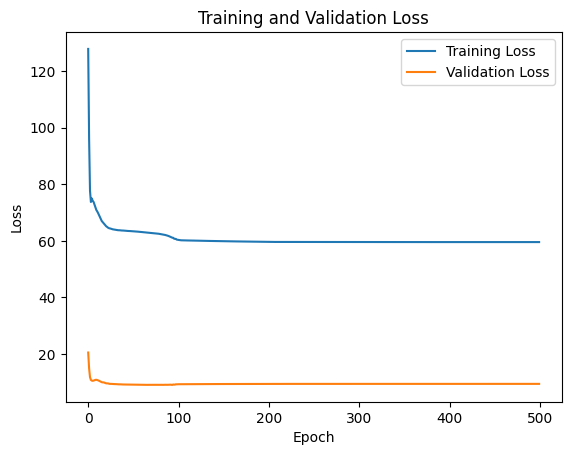

Model saved to models/trainable_gcesn_1l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 14.39%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.52%

Total Training Time: 17.11s
Max CPU Usage: 50.90%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%


In [42]:
set_seed(42)
trainable_gcesn_mutag = TrainableGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag.count_parameters()}\n")
                
single_train(trainable_gcesn_mutag, mutag_train_loader, mutag_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_1l_mutag.pth',
                binary_classification=True, is_esn=True)

In [44]:
trainable_gcesn_mutag = TrainableGCESN(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=6)
trainable_gcesn_mutag.load_state_dict(torch.load('models/trainable_gcesn_1l_mutag.pth'))
single_test(trainable_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(trainable_gcesn_mutag.to(device), mutag_test_loader)

Accuracy: 0.8421
Average Sensitivity (Recall): 0.8846
Average Specificity: 0.7500

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 14.00%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


### EMCI-AD

Total number of trainable parameters: 690

Epoch 1, Train Loss: 848060.4930419922, Val Loss: 30282.50244140625
Time: 0.06s, CPU: 17.40%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 292123.59375, Val Loss: 5871.326904296875
Time: 0.06s, CPU: 26.70%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 3, Train Loss: 100376.08856201172, Val Loss: 6966.4278564453125
Time: 0.06s, CPU: 19.65%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 47102.153579711914, Val Loss: 3504.4424438476562
Time: 0.06s, CPU: 26.25%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Loss: 19642.681915283203, Val Loss: 1901.0745239257812
Time: 0.06s, CPU: 26.65%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 6, Train Loss: 13036.037582397461, Val Loss: 1472.3210754394531
Time: 0.06s, CPU: 30.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 7, Train Loss: 12837.297637939453, Val Loss: 2024.5742797851562
Time: 0.06s, CPU: 21.55%, Memory: 3.32GB, GPU: 0.0

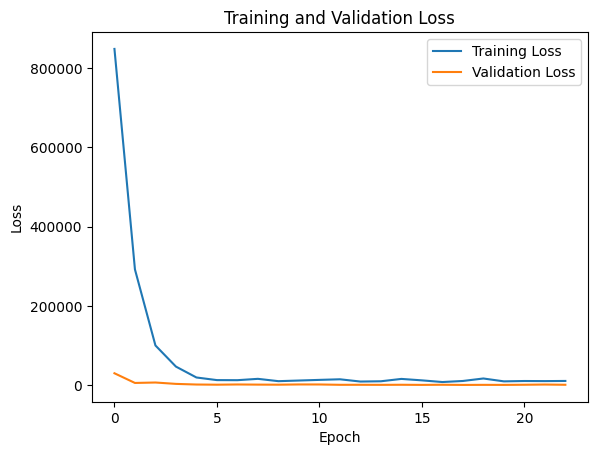

Model saved to models/trainable_gcesn_1l_emci.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 28.42%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.43%

Total Training Time: 1.45s
Max CPU Usage: 45.10%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%


In [48]:
set_seed(42)
trainable_gcesn_emci = TrainableGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_emci.count_parameters()}\n")
                
single_train(trainable_gcesn_emci, emci_train_loader, emci_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_1l_emci.pth',
                binary_classification=True, is_esn=True)

In [49]:
trainable_gcesn_emci = TrainableGCESN(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=6)
trainable_gcesn_emci.load_state_dict(torch.load('models/trainable_gcesn_1l_emci.pth'))
single_test(trainable_gcesn_emci.to(device), emci_test_loader)
inference_performance(trainable_gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.5556
Average Sensitivity (Recall): 0.3636
Average Specificity: 0.6875

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 10.02%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


### SLIM160

Total number of trainable parameters: 707

Epoch 1, Train Loss: 30175033040.0, Val Loss: 1848747456.0
Time: 0.18s, CPU: 25.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 2, Train Loss: 10975893320.0, Val Loss: 773108118.0
Time: 0.94s, CPU: 66.55%, Memory: 3.33GB, GPU: 0.06GB, GPU Util: 8.50%
Epoch 3, Train Loss: 3757652516.0, Val Loss: 471202380.0
Time: 1.24s, CPU: 82.20%, Memory: 3.33GB, GPU: 0.06GB, GPU Util: 6.50%
Epoch 4, Train Loss: 4390581598.0, Val Loss: 356241753.0
Time: 0.96s, CPU: 83.95%, Memory: 3.34GB, GPU: 0.06GB, GPU Util: 8.50%
Epoch 5, Train Loss: 2991954338.0, Val Loss: 215771458.5
Time: 0.98s, CPU: 65.10%, Memory: 3.32GB, GPU: 0.06GB, GPU Util: 8.00%
Epoch 6, Train Loss: 2142898174.0, Val Loss: 172875087.0
Time: 0.23s, CPU: 61.60%, Memory: 3.33GB, GPU: 0.06GB, GPU Util: 22.50%
Epoch 7, Train Loss: 1995084944.0, Val Loss: 197384715.0
Time: 1.28s, CPU: 88.95%, Memory: 3.32GB, GPU: 0.06GB, GPU Util: 3.50%
Epoch 8, Train Loss: 1610074958.0, Val Loss: 158783773.5


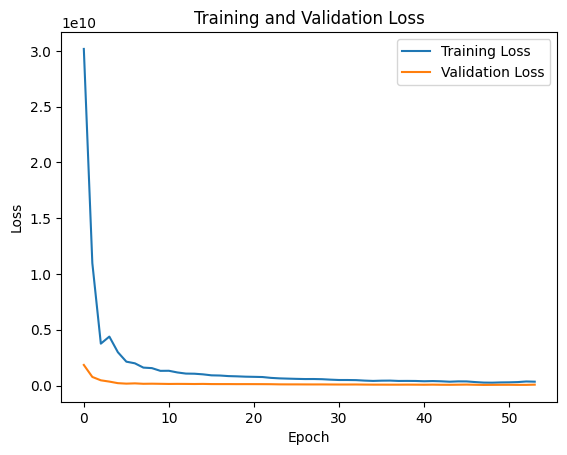

Model saved to models/trainable_gcesn_1l_slim160.pth
Average Time per Epoch: 0.27s
Average CPU Usage: 46.24%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.06GB
Average GPU Utilization: 33.31%

Total Training Time: 14.68s
Max CPU Usage: 88.95%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.06GB
Max GPU Utilization: 43.00%


In [50]:
set_seed(42)
trainable_gcesn_slim160 = TrainableGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_slim160.count_parameters()}\n")
                
single_train(trainable_gcesn_slim160, slim160_train_loader, slim160_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_1l_slim160.pth',
                binary_classification=True, is_esn=True)

In [51]:
trainable_gcesn_slim160 = TrainableGCESN(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=6)
trainable_gcesn_slim160.load_state_dict(torch.load('models/trainable_gcesn_1l_slim160.pth'))
single_test(trainable_gcesn_slim160.to(device), slim160_test_loader)
inference_performance(trainable_gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.5405
Average Sensitivity (Recall): 0.8235
Average Specificity: 0.3000

Average Inference Time per Batch: 0.0034s
Average CPU Usage: 30.75%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 1.00%
